# Objectives

### 1. Data analysis:
- Which station has the most number of units?
- What is the total number of entries & exits across the subway system for February 1, 2013?
- Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
- What stations have seen the most usage growth/decline in 2013?
- What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?
- Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?

### 2. Visualization:
- Plot the daily row counts for data files in Q1 2013.
- Plot the daily total number of entries & exits across the system for Q1 2013.
- Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

# Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


- C/A      = Control Area (A002)
- UNIT     = Remote Unit for a station (R051)
- SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
- STATION  = Represents the station name the device is located at
- LINENAME = Represents all train lines that can be boarded at this station
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
- DATE     = Represents the date (MM-DD-YY)
- TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
- DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- ENTRIES  = The comulative entry register value for a device
- EXIST    = The cumulative exit register value for a device

# Read data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1.1 Which station has the most number of units?

For this question, since it doesn't provide me a specific time range, I am using the latest data on http://web.mta.info/developers/turnstile.html, which is dated as <b>Saturday, June 26, 2021</b>

In [2]:
#read raw data
raw_data = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_210626.txt')
raw_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,00:00:00,REGULAR,7589159,2594185
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,04:00:00,REGULAR,7589165,2594190
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,08:00:00,REGULAR,7589174,2594207
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,12:00:00,REGULAR,7589214,2594253
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,16:00:00,REGULAR,7589300,2594278


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209411 entries, 0 to 209410
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count   Dtype 
---  ------                                                                --------------   ----- 
 0   C/A                                                                   209411 non-null  object
 1   UNIT                                                                  209411 non-null  object
 2   SCP                                                                   209411 non-null  object
 3   STATION                                                               209411 non-null  object
 4   LINENAME                                                              209411 non-null  object
 5   DIVISION                                                              209411 non-null  object
 6   DATE                                                                  209411 non-null  objec

In [4]:
# rename columns
data = raw_data.rename(
    columns = {
        'C/A' : 'c/a',
        'UNIT' : 'unit',
        'SCP' : 'scp',
        'STATION' : 'station',
        'LINENAME' : 'linename',
        'DIVISION' : 'division', 
        'DATE' : 'date',
        'TIME' : 'time',
        'DESC' : 'desc',
        'ENTRIES' : 'entries',
        'EXITS                                                               ' : 'exits' # so many blanks in EXITS
    }
)

# concatenate date and time and convert all three from string to datetime data type
data['datetime'] = data['date'].str.cat(data['time'], sep = ' ').astype('datetime64[ns]')
data['date'] = data['date'].astype('datetime64[ns]')
data['time'] = data['time'].astype('datetime64[ns]')

Before analyzing data, we should do sinaty check first 

In [5]:
# sanity check for numerical data 
data.describe()

,entries,exits
count,2.094110e+05,2.094110e+05
mean,4.202990e+07,3.374834e+07
std,2.192599e+08,1.935976e+08
min,0.000000e+00,0.000000e+00
25%,2.162670e+05,9.754700e+04
50%,1.411375e+06,8.559970e+05
75%,6.032683e+06,3.970092e+06
max,2.147410e+09,2.122859e+09


In [6]:
# Sanity check for categorical and time series data 
data.describe(include=['object','datetime'])

,c/a,unit,scp,station,linename,division,date,time,desc,datetime
count,209411,209411,209411,209411,209411,209411,209411,209411,209411,209411
unique,750,469,225,379,114,6,7,11690,2,13182
top,PTH22,R549,00-00-00,34 ST-PENN STA,1,IRT,2021-06-24 00:00:00,2021-07-02 16:00:00,REGULAR,2021-06-25 16:00:00
freq,1800,2847,19449,4239,25441,75046,30074,17951,208680,2569
first,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-19 00:00:00,2021-07-02 00:00:00,NaN,2021-06-19 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-25 00:00:00,2021-07-02 23:59:58,NaN,2021-06-25 23:59:18


In [7]:
# check if there is null values
data.isnull().sum()

c/a         0
unit        0
scp         0
station     0
linename    0
division    0
date        0
time        0
desc        0
entries     0
exits       0
datetime    0
dtype: int64

In [8]:
unit_by_station = data.groupby(['station']).nunique()\
.unit.sort_values(ascending = False).reset_index().head(10)

unit_by_station.columns = ['station', 'unit_cnt']

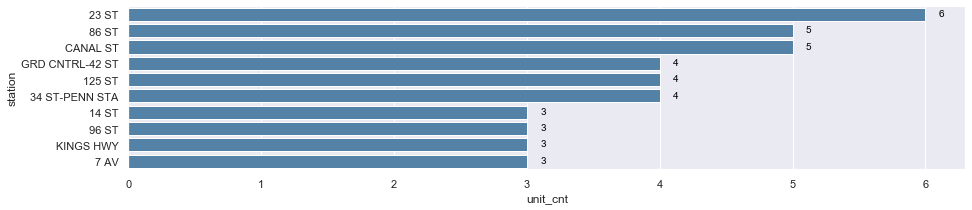

In [9]:
def plot_bar(data, x, y):
    plt.figure(figsize = (15,3))
    sns.set(style = "darkgrid")
    ax = sns.barplot(
        x = x,
        y = y,
        data = data,
        color = 'steelblue'
    )
    
    # annote
    for i in ax.patches:
        ax.text(
            i.get_width() + 0.1,
            i.get_y() + 0.5,
            '{0:.0f}'.format(i.get_width()),
            fontsize = 10,
            color='black'
        )
    

plot_bar(unit_by_station, 'unit_cnt', 'station')

As we can see, <b>23ST</b> is the station has the most number of units

# 1.2 What is the total number of entries & exits across the subway system for February 1, 2013?

To answer this question, we need to download all the data from 2013.

Quite different from the latest dataset we just used, the 2013 data was stored as multiple records according to the clarification from MTA - we need to stack same columns and keep one record per row for our further analysis 

In [10]:
def getDate(start, end, delta):
    """
    To generate all record dates in 2013 
    """
    start = datetime.strptime(start,'%Y/%m/%d')
    end = datetime.strptime(end,'%Y/%m/%d')
    dates = []
    cur = start
    while cur < end:
        dates.append(cur.strftime('%y%m%d'))
        cur += timedelta(delta)
    return dates

def get2013Data(start, end, delta):
    """
    To iterate by columns and stack them up
    """
    col_name = [
        'c/a','unit','scp',
        'date0','time0','desc0','entries0','exits0',
        'date1','time1','desc1','entries1','exits1',
        'date2','time2','desc2','entries2','exits2',
        'date3','time3','desc3','entries3','exits3',
        'date4','time4','desc4','entries4','exits4',
        'date5','time5','desc5','entries5','exits5',
        'date6','time6','desc6','entries6','exits6',
        'date7','time7','desc7','entries7','exits7',
    ]
    
    dates = getDate(start, end, delta)
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    df_list = []

    for date in dates:
        print('Downloading data from {}...'.format(date))
        df_list.append(pd.read_csv(url.format(date), names = col_name))
        print('Download completed')
    
    return pd.concat(df_list)
    
def stack_column(data):
    """
    stack the data
    """
    
    col_names = ['c/a','unit','scp','date','time','desc','entries','exits']
    df = pd.DataFrame(columns = col_names)
    for i in range(0,8):
        col_idx = [0, 1, 2, 5*i+3, 5*i+4, 5*i+5, 5*i+6, 5*i+7]
        temp = data.iloc[:, col_idx]
        temp.columns = col_names
        df = df.append(temp, ignore_index = True)
        df = df.sort_values(['c/a','unit','scp','date','time'])
        df[['entries','exits']] = df[['entries','exits']].apply(pd.to_numeric)
    return df   
    
data_2013 = get2013Data('2013/01/05', '2014/01/04', 7)
data = stack_column(data_2013)
data

Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed
Download completed


,c/a,unit,scp,date,time,desc,entries,exits
0,A002,R051,02-00-00,01-01-13,03:00:00,REGULAR,3932284.0,1355714.0
1,A002,R051,02-00-00,01-01-13,07:00:00,REGULAR,3932299.0,1355721.0
2,A002,R051,02-00-00,01-01-13,11:00:00,REGULAR,3932327.0,1355774.0
3,A002,R051,02-00-00,01-01-13,15:00:00,REGULAR,3932427.0,1355811.0
4,A002,R051,02-00-00,01-01-13,19:00:00,REGULAR,3932662.0,1355849.0
...,...,...,...,...,...,...,...,...
12264491,TRAM2,R469,00-05-01,NaN,NaN,NaN,NaN,NaN
12293638,TRAM2,R469,00-05-01,NaN,NaN,NaN,NaN,NaN
12322984,TRAM2,R469,00-05-01,NaN,NaN,NaN,NaN,NaN
12352077,TRAM2,R469,00-05-01,NaN,NaN,NaN,NaN,NaN


In [11]:
def changeDtype(data):
    """
    add a datetime column for further calculation
    """
    data['datetime'] = data['date'].str.cat(data['time'], sep = ' ').astype('datetime64[ns]')
    data['date'] = data['date'].astype('datetime64[ns]')
    data['time'] = data['time'].astype('datetime64[ns]')
    return data

data = changeDtype(data)

In [12]:
data

,c/a,unit,scp,date,time,desc,entries,exits,datetime
0,A002,R051,02-00-00,2013-01-01,2021-07-02 03:00:00,REGULAR,3932284.0,1355714.0,2013-01-01 03:00:00
1,A002,R051,02-00-00,2013-01-01,2021-07-02 07:00:00,REGULAR,3932299.0,1355721.0,2013-01-01 07:00:00
2,A002,R051,02-00-00,2013-01-01,2021-07-02 11:00:00,REGULAR,3932327.0,1355774.0,2013-01-01 11:00:00
3,A002,R051,02-00-00,2013-01-01,2021-07-02 15:00:00,REGULAR,3932427.0,1355811.0,2013-01-01 15:00:00
4,A002,R051,02-00-00,2013-01-01,2021-07-02 19:00:00,REGULAR,3932662.0,1355849.0,2013-01-01 19:00:00
...,...,...,...,...,...,...,...,...,...
12264491,TRAM2,R469,00-05-01,NaT,NaT,NaN,NaN,NaN,NaT
12293638,TRAM2,R469,00-05-01,NaT,NaT,NaN,NaN,NaN,NaT
12322984,TRAM2,R469,00-05-01,NaT,NaT,NaN,NaN,NaN,NaT
12352077,TRAM2,R469,00-05-01,NaT,NaT,NaN,NaN,NaN,NaT


In [13]:
def hourlyDiff(data, col):
    s = data[col].diff().fillna(0)
    return s

data['hourly_entries'] = hourlyDiff(data, 'entries')
data['hourly_exits'] = hourlyDiff(data, 'exits')

In [14]:
data.describe()

,entries,exits,hourly_entries,hourly_exits
count,1.146441e+07,1.146441e+07,1.238082e+07,1.238082e+07
mean,5.034486e+06,2.971423e+06,6.359200e+01,8.984086e+01
std,3.292653e+07,3.299601e+07,1.147326e+06,1.155234e+06
min,-9.314769e+08,-8.789686e+08,-9.314769e+08,-9.797130e+08
25%,3.364450e+05,1.932042e+05,0.000000e+00,0.000000e+00
50%,1.982436e+06,1.216322e+06,3.800000e+01,2.800000e+01
75%,4.972726e+06,3.579545e+06,1.900000e+02,1.300000e+02
max,9.168487e+08,9.797130e+08,9.314769e+08,9.719247e+08


Apparently, there are some data errors in this dataset, like extremely large outliers and negative values in hourly entries and exits.

In [15]:
# add month and year
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year

data = data[
    ['c/a', 'unit', 'scp', 
     'datetime', 'date', 'time', 'month', 'year',
     'hourly_entries', 'hourly_exits',
     'entries','exits']
]

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12380824 entries, 0 to 12380823
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   c/a             object        
 1   unit            object        
 2   scp             object        
 3   datetime        datetime64[ns]
 4   date            datetime64[ns]
 5   time            datetime64[ns]
 6   month           float64       
 7   year            float64       
 8   hourly_entries  float64       
 9   hourly_exits    float64       
 10  entries         float64       
 11  exits           float64       
dtypes: datetime64[ns](3), float64(6), object(3)
memory usage: 1.2+ GB


In [17]:
def clean_data(data):
    # fill missing value
    data['hourly_entries'] = data['hourly_entries'].fillna(0)
    data['hourly_exits'] = data['hourly_exits'].fillna(0)
    
    # if negative traffic, replace it with 0  
    data['hourly_entries'][data['hourly_entries'] < 0] = 0 
    data['hourly_exits'][data['hourly_exits'] < 0] = 0
    
    # for abnormal large value, set to 0
    data['hourly_entries'][data['hourly_entries'] >= 6000] = 0 
    data['hourly_exits'][data['hourly_exits'] >= 6000] = 0
    return data

data = clean_data(data)

In [18]:
res = data[data['date'] == '2013-02-01'].groupby('date')\
['hourly_entries','hourly_exits'].sum().rename(
    columns = {
        'hourly_entries':'total_entries',
        'hourly_exits': 'total_exits'
    }
)
res

,total_entries,total_exits
date,,
2013-02-01,5818588.0,4516096.0


([], <a list of 0 Text xticklabel objects>)

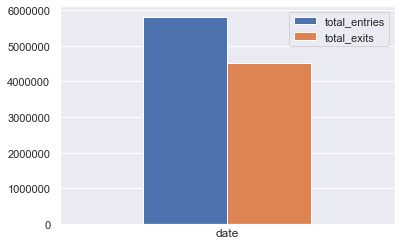

In [19]:
res.plot(kind = 'bar')
plt.xticks([])

For February 1, 2013: 
- The total number of entries: 5,818,588
- Total number of exits: 4,516,096

# 1.3 Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?

In [20]:
data['hourly_traffic'] = data['hourly_entries'] + data['hourly_exits']

In [21]:
def getStation(data):
    station = pd.read_excel(
        'Remote-Booth-Station.xls',
        header = 0,
        names = ['unit','c/a','station','line_name','division']
    )
    
    df = pd.merge(
        left = data,
        right = station,
        on = ['unit','c/a']
    )
    return df

mta = getStation(data)

In [22]:
# get data from February 1, 2013
df_1302 = mta[mta['date'] == '2013-01-01']
# get top 5 busiest stations
top_5_stations = df_1302.groupby(['station'])['hourly_traffic'].sum().reset_index().sort_values('hourly_traffic', ascending = False).head(5)
top_5_stations

,station,hourly_traffic
67,34 ST-PENN STA,128109.0
74,42 ST-TIMES SQ,100674.0
66,34 ST-HERALD SQ,98215.0
73,42 ST-PA BUS TE,92682.0
18,14 ST-UNION SQ,85845.0


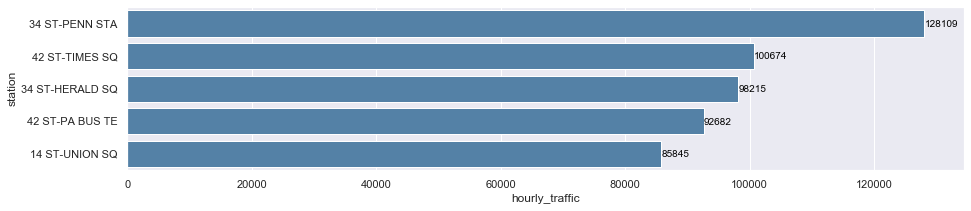

In [23]:
plot_bar(top_5_stations, 'hourly_traffic', 'station')

In [24]:
# get turnstile field
df_1302['turnstile'] = df_1302['c/a'].str.cat([df_1302['unit'],df_1302['scp']], sep = ' ')
# get top 5 busiest turnstiles
top_5_turnstiles = df_1302.groupby(
    ['turnstile']
)['hourly_traffic'].sum().reset_index().sort_values(
    'hourly_traffic',
    ascending = False
).head(5)

top_5_turnstiles

,turnstile,hourly_traffic
2814,R151 R033 00-00-03,6278.0
2815,R151 R033 00-00-04,6130.0
670,H007 R248 00-00-00,5898.0
2813,R151 R033 00-00-02,5728.0
683,H009 R235 00-00-03,5677.0


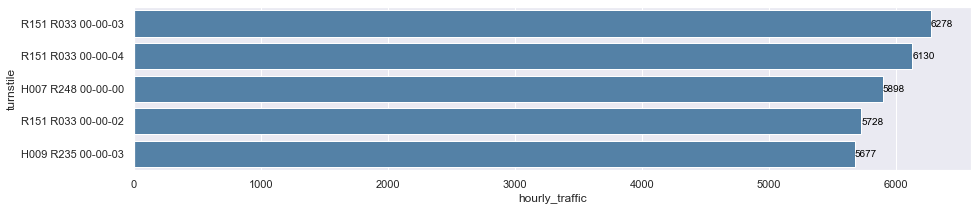

In [25]:
plot_bar(top_5_turnstiles,'hourly_traffic','turnstile')

As we can see, <b>34 ST-PENN</b> station was the busiest station and <b>R151 R033 00-00-03</b> is the busiest turnstile

# 1.4 What stations have seen the most usage growth/decline in 2013?
I compare the average traffic of 1st half year and 2nd half year across all stations.

In [26]:
df_13 = mta[mta['year'] == 2013].groupby(['station','month'])\
['hourly_traffic'].sum().reset_index().rename(
    columns = {"hourly_traffic":"usage"}
)


df_13_1st_half = mta[(mta['year'] == 2013) & (mta['month'] < 7)].groupby(
    ['station']
)['hourly_traffic'].sum().reset_index().rename(
    columns = {"hourly_traffic":"1st_half_usage"}
)

df_13_2nd_half = mta[(mta['year'] == 2013) & (mta['month'] >= 7)].groupby(
    ['station']
)['hourly_traffic'].sum().reset_index().rename(
    columns = {"hourly_traffic":"2nd_half_usage"}
)


df_13_all = pd.merge(
    left = df_13_1st_half, 
    right = df_13_2nd_half,
    on = ['station', 'station'],
    how = 'inner'
)

# get mean by dividing 6 months
df_13_all['usage_diff'] = df_13_all['2nd_half_usage'] // 6 - df_13_all['1st_half_usage'] // 6

top_5_growth = df_13_all.sort_values(['usage_diff'], ascending = False).head(5)
top_5_decline = df_13_all.sort_values(['usage_diff'], ascending = True).head(5)

In [27]:
# get top 5 growth
top_5_growth

,station,1st_half_usage,2nd_half_usage,usage_diff
158,BOWLING GREEN,8513071.0,10127365.0,269049.0
319,PATH WTC,12021098.0,13133717.0,185436.0
346,SMITH-9 ST,464745.0,1470542.0,167633.0
229,FULTON ST,12551964.0,13530136.0,163028.0
74,42 ST-TIMES SQ,30684705.0,31558900.0,145699.0


In [28]:
top_5_decline

,station,1st_half_usage,2nd_half_usage,usage_diff
373,WHITEHALL ST,4107241.0,2169070.0,-323029.0
263,JOURNAL SQUARE,6652028.0,5261000.0,-231838.0
176,CASTLE HILL AVE,1923806.0,927544.0,-166044.0
246,HOWARD BCH-JFK,1341193.0,457770.0,-147237.0
189,CORTLANDT ST,1684663.0,1103142.0,-96920.0


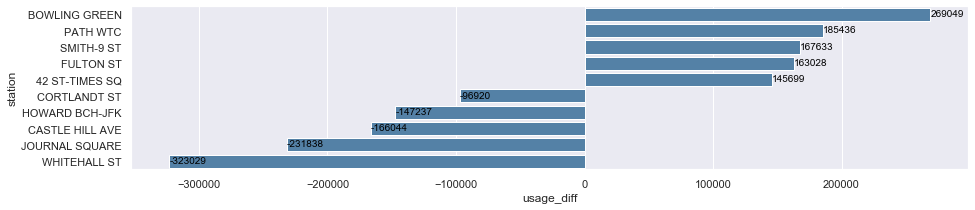

In [29]:
# print all diff in one diagram 
plot_bar(
    pd.concat(
        [
            top_5_growth,
            top_5_decline.sort_values(
                'usage_diff',
                ascending = False
            )
        ]
    ),
    'usage_diff',
    'station'
)

As we can see, the station with  most growth was <b>BOWLING GREEN</b> and the one with most decline was <b>WHITEHALL ST	</b>

# 1.5 What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [30]:
def least_busy_5(data):
    data = data[data['year'] == 2013].groupby(
        ['date']
    )['hourly_traffic'].sum().reset_index().rename(
        columns = {
            'hourly_traffic':'daily_traffic'
        }
    ).sort_values('daily_traffic').head(5)
    return data

df_13_date = least_busy_5(mta)
df_13_date

,date,daily_traffic
358,2013-12-25,3394457.0
0,2013-01-01,3749786.0
331,2013-11-28,4212686.0
39,2013-02-09,4239141.0
33,2013-02-03,4378539.0


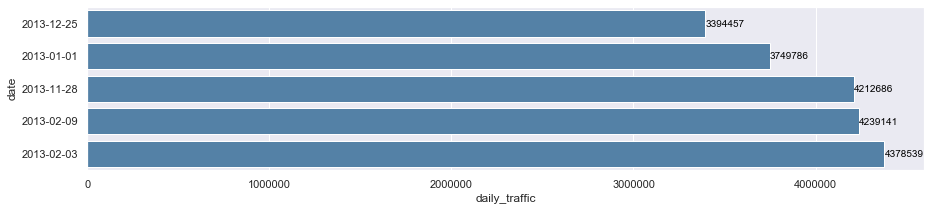

In [31]:
plot_bar( df_13_date, 'daily_traffic', df_13_date['date'].astype('str'))

The least busy dates are <b>2013-12-25, 2013-01-01, 2013-11-28, 2013-02-09 and 2013-02-03</b>.

In [32]:
# close stations should have 0 traffic in a particular date  

def getClose(data):
    
    all_station = data[data['year'] == 2013].groupby(
        ['date','station']
    )['hourly_traffic'].sum().reset_index().rename(
        columns = {
            'hourly_traffic':'daily_traffic'
        }
    
    )
    
    close = all_station[all_station['daily_traffic'] == 0]
    return close
    
    
close_station = getClose(mta)

print('In 2013, there were {} days on which at least one station was closed entirely '.format(len(set(close_station.date))))
close_station

In 2013, there were 152 days on which at least one station was closed entirely 


,date,station,daily_traffic
512,2013-01-02,BEACH 90 ST,0.0
1251,2013-01-04,BEACH 90 ST,0.0
1622,2013-01-05,BEACH 90 ST,0.0
1876,2013-01-06,14TH STREET,0.0
1971,2013-01-06,9TH STREET,0.0
...,...,...,...
128989,2013-12-08,BEACH 25 ST,0.0
128993,2013-12-08,BEACH 67 ST,0.0
129026,2013-12-08,CENTRAL AVE,0.0
129188,2013-12-08,SENECA AVE,0.0


In 2013, there were <b>152</b> days on which at least one station was closed entirely

In [33]:
def not_full(data):
    """
    To find not fully operating stations, first we need to find stations with c/a that had 0 daily traffic.
    Then we remove the duplicated stations in each day.
    Finally the date and stations left are our result.
    
    
    """
    all_station = data[data['year'] == 2013].groupby(
        ['date','station','c/a']
    )['hourly_traffic'].sum().reset_index().rename(
        columns = {
            'hourly_traffic':'daily_traffic'
        }
    )
        
    not_full = all_station[all_station ['daily_traffic'] == 0].drop_duplicates(
        subset = ['date', 'station'],
        keep='first'
    )
        
    return not_full[['date', 'station']]
        
not_full_station = not_full(mta)

print('In 2013, there were {} days on which at least one station was not fully operating '.format(len(set(not_full_station.date))))
not_full_station

In 2013, there were 361 days on which at least one station was not fully operating 


,date,station
69,2013-01-01,161 ST-YANKEE
137,2013-01-01,28 ST
176,2013-01-01,42 ST-GRD CNTRL
213,2013-01-01,51 ST
341,2013-01-01,BROAD ST
...,...,...
256518,2013-12-25,BROAD ST
256864,2013-12-25,WALL ST
257232,2013-12-26,BROAD ST
257668,2013-12-27,161 ST-YANKEE


In 2013, there were <b>361</b> days on which at least one station was not fully operating

# 1.6 Bonus: What hour is the busiest for station CANAL ST in Q1 2013?

In [34]:
def canal(data):
    """
    Find top 5 busiest hours for CANAL ST
    """
    canal = data[
        (data['year'] == 2013) &
        (data['month'] < 4) & 
        (data['station'] == 'CANAL ST')
    ]
                  
    canal['hour'] = canal['datetime'].dt.hour
    top_busy = canal.groupby(['hour'])['hourly_traffic'].mean().reset_index().sort_values(
        ['hourly_traffic'],
        ascending = False
    ).head(5)

    return top_busy

top_busy_canal = canal(mta)
top_busy_canal

,hour,hourly_traffic
20,20,663.344725
21,21,661.749714
17,17,608.279365
19,19,561.169858
16,16,509.308223


The top 5 busy hours were <b>20, 21, 17, 19 and 16</b>, where <b>20</b> was the busiest hour

# 2.1 Plot the daily row counts for data files in Q1 2013

In [35]:
# get data from 2013 q1
q1_2013 = mta[(mta['year'] == 2013) & (mta['month'] < 4)]

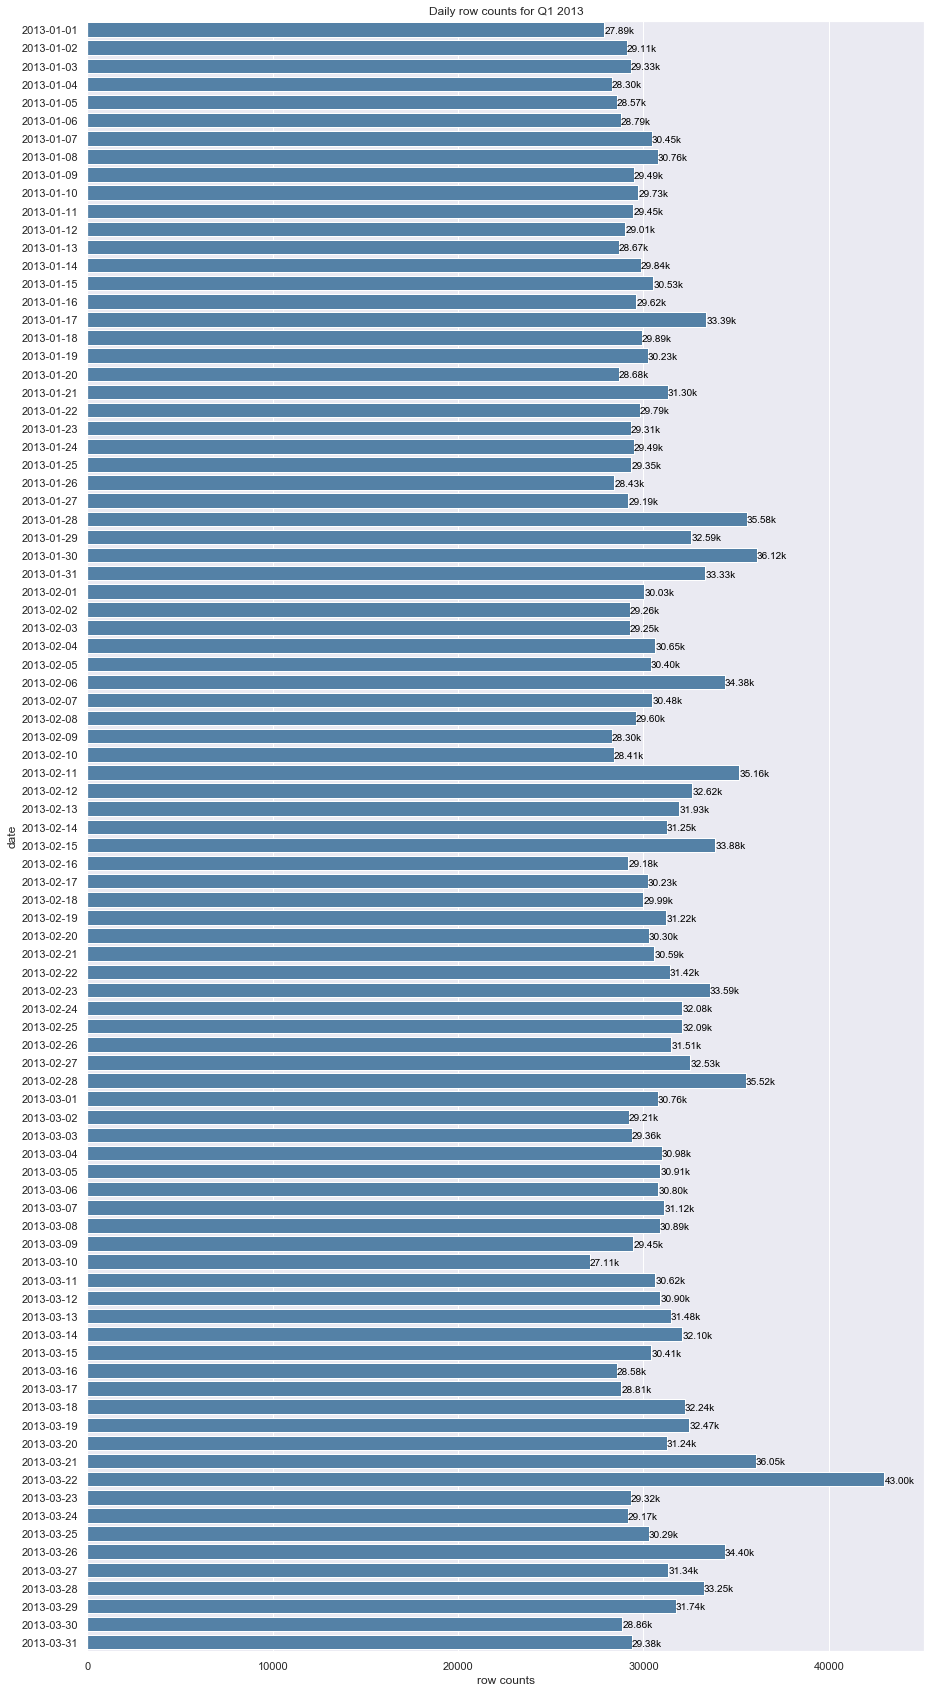

In [36]:
def plot_daily_row(data):
    """
    Plot the daily row counts for data files in Q1 2013
    
    """
    daily_count = data.groupby(['date'])['c/a'].count().reset_index().rename(
        columns = {
        'c/a':'row_cnt'
        }   
    )
    
    
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 30))
    

    sns.barplot(
        'row_cnt',
        daily_count['date'].astype('str'),
        data = daily_count,
        color = 'steelblue'
    )
    
    for i in ax.patches:
        ax.text(i.get_width() + 0.2,
                i.get_y() + 0.6,
                '{0:.2f}k'.format(i.get_width()/1000),
                fontsize = 10,
                color='black'
               )
    plt.xlabel('row counts')
    plt.ylabel('date')
    plt.title('Daily row counts for Q1 2013')
    
plot_daily_row(q1_2013)

# 2.2 Plot the daily total number of entries & exits across the system for Q1 2013.


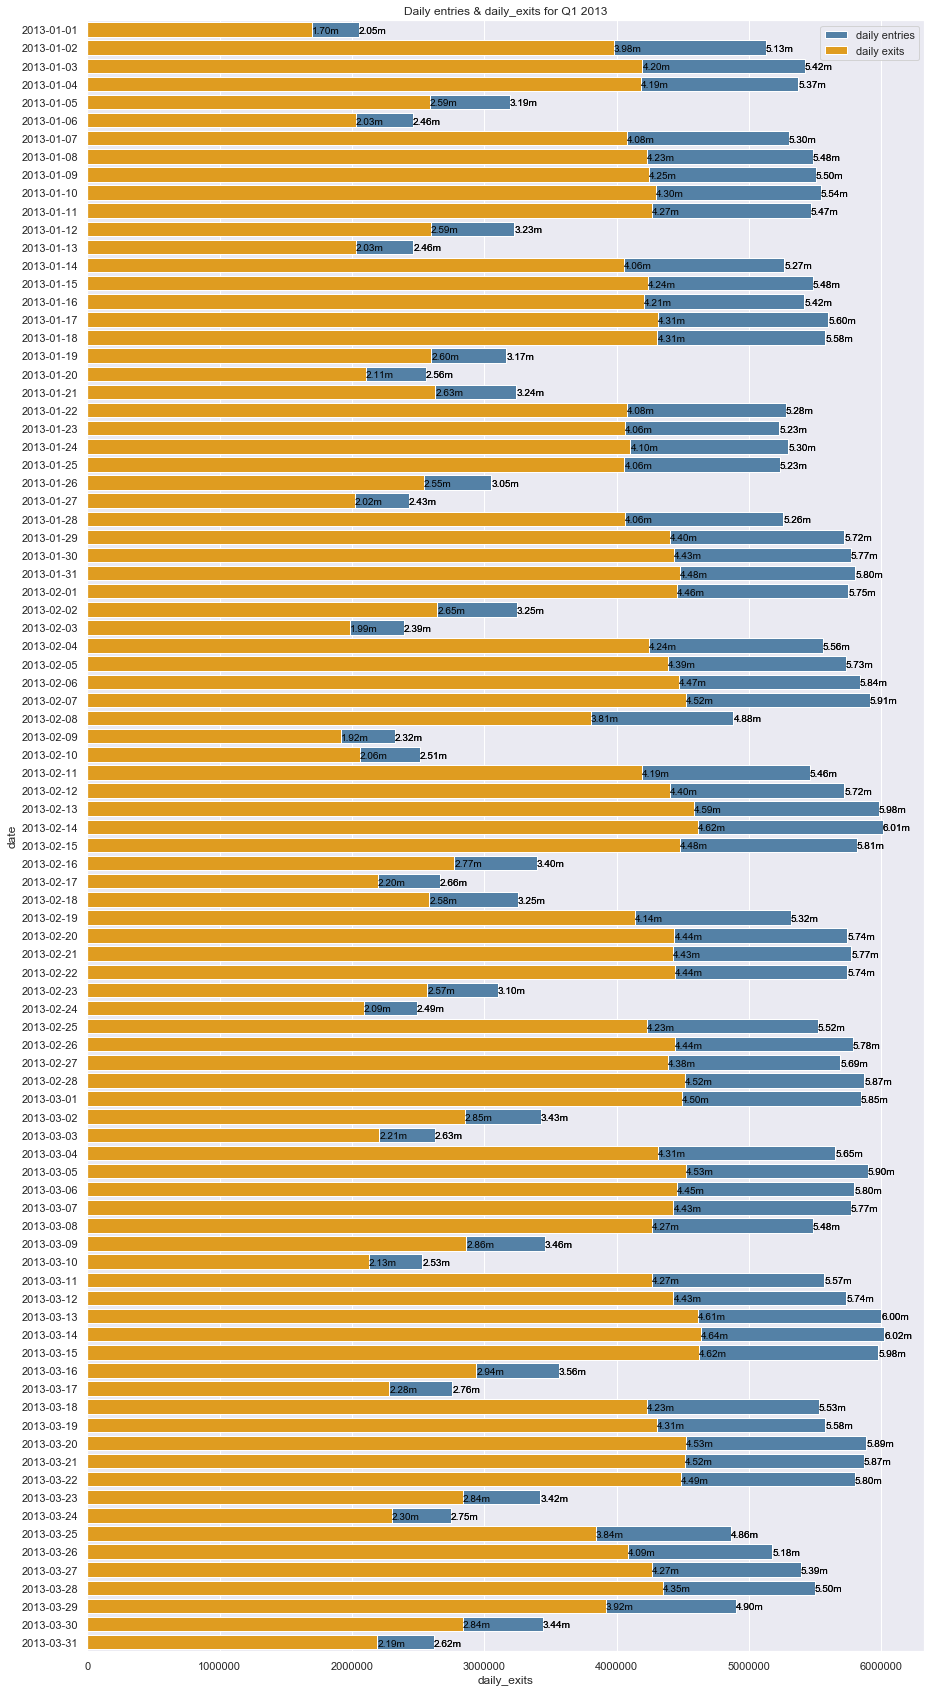

In [37]:
def plot_daily_ee(data):
    
    daily_ee = data.groupby(['date'])['hourly_entries', 'hourly_exits'].sum()\
    .reset_index().rename(
        columns = {
            'hourly_entries':'daily_entries',
            'hourly_exits': 'daily_exits'  
        }   
    )
    
        
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 30))
    

    plt.xlabel('daily entries & daily_exits')
    plt.ylabel('date')
    plt.title('Daily entries & daily_exits for Q1 2013')
    
    sns.barplot('daily_entries',
                daily_ee['date'].astype('str'),
                data = daily_ee,
                color = 'steelblue',
                label = 'daily entries'
               )
    
    for i in ax.patches:
        ax.text(i.get_width(),
                i.get_y() + 0.6,
                '{0:.2f}m'.format(i.get_width()/1000000),
                fontsize = 10,
                color='black'
               )
        
    sns.barplot(daily_ee['daily_exits'],
                daily_ee['date'].astype('str'),
                data = daily_ee,
                color = 'orange', 
                label = 'daily exits'
               )
    
    for i in ax.patches:
        ax.text(i.get_width(),
                i.get_y() + 0.6,
                '{0:.2f}m'.format(i.get_width()/1000000),
                fontsize = 10,
                color='black'
               )
    plt.legend()
                
plot_daily_ee(q1_2013)

# 2.3 Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.


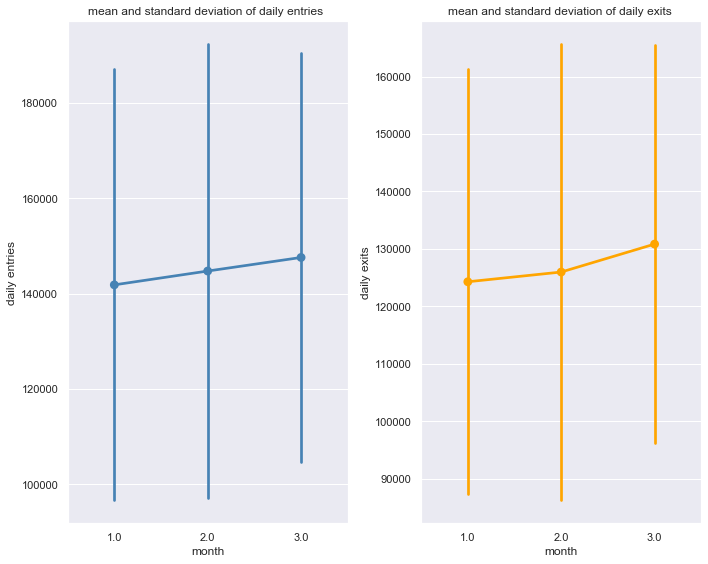

In [39]:
def plot_34st(data):
    # get data from 34 ST-PENN STA 
    penn = data[data['station'] == '34 ST-PENN STA']
    # date level
    penn_date = penn.groupby(['month','date'])['hourly_entries','hourly_exits'].sum()\
    .rename(
        columns = {
            'hourly_entries': 'daily_entries',
            'hourly_exits': 'daily_exits'
        }
    ).reset_index()
    
    # month level
    penn_month = penn_date.groupby(['month'])['daily_entries','daily_exits'].agg([np.mean, np.std]).reset_index()
    
    #plot bar chart
    sns.set(style = 'darkgrid')
    fig, axes = plt.subplots(1, 2, figsize = (10,8))
    ax = sns.pointplot(
        'month',
        'daily_entries',
        data = penn_date,
        ax = axes[0],
        color = 'steelblue',
        ci = 'sd'
    )
    ax.set(
        title = 'mean and standard deviation of daily entries ',
        xlabel = "month",
        ylabel = "daily entries",
    )

    ax = sns.pointplot(
        'month',
        'daily_exits',
        data = penn_date,
        ax = axes[1],
        color ='orange',
        ci = 'sd'
    )
    
    ax.set(
    title = 'mean and standard deviation of daily exits ',
    xlabel = "month",
    ylabel = "daily exits"
    )
    
    plt.tight_layout()
    
plot_34st(q1_2013)

# 2.4 Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
To observe all percentiles at the same time as well as the distribution of the data, the best way is to use boxplot, which is displayed below

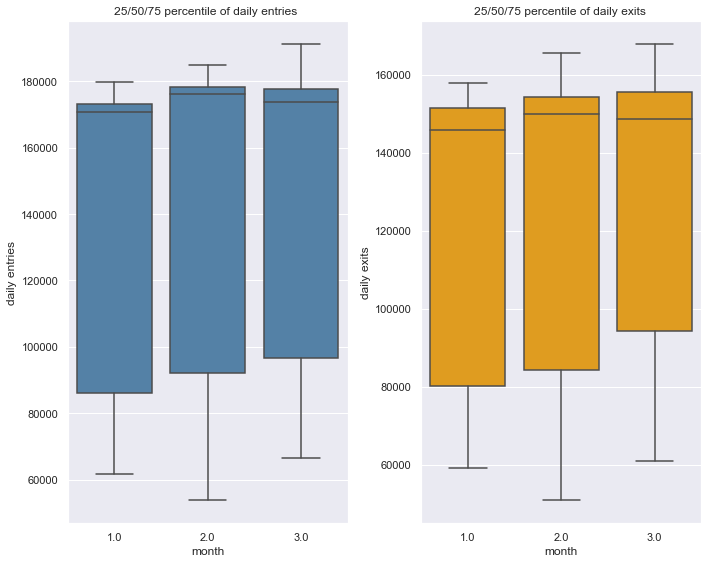

In [40]:
def plot_percentile(data):
    penn = data[data['station'] == '34 ST-PENN STA']
    # date level
    penn_date = penn.groupby(['month','date'])['hourly_entries','hourly_exits'].sum()\
    .rename(
        columns = {
            'hourly_entries': 'daily_entries',
            'hourly_exits': 'daily_exits'
        }
    ).reset_index()
    
    #plot bar chart
    sns.set(style = 'darkgrid')
    fig, axes = plt.subplots(1, 2, figsize = (10,8))
    ax = sns.boxplot(
        'month',
        'daily_entries',
        data = penn_date,
        ax = axes[0],
        color = 'steelblue',
    )
    ax.set(
        title = '25/50/75 percentile of daily entries ',
        xlabel = "month",
        ylabel = "daily entries",
    )

    ax = sns.boxplot(
        'month',
        'daily_exits',
        data = penn_date,
        ax = axes[1],
        color ='orange',
    )
    
    ax.set(
    title = '25/50/75 percentile of daily exits ',
    xlabel = "month",
    ylabel = "daily exits"
    )
    
    plt.tight_layout()
    
    # get percentiles
    percentiles_entries = penn_date.groupby('month')['daily_entries'].describe(
        percentiles =[0.25, 0.5, 0.75]
    ).reset_index()
    
    percentiles_exits = penn_date.groupby('month')['daily_exits'].describe(
        percentiles =[0.25, 0.5, 0.75]
    ).reset_index()
    
    return percentiles_entries, percentiles_exits
    
percentiles_entries, percentiles_exits = plot_percentile(q1_2013)

For more details, the 25/50/75 percentiles for entries & exits for each month in Q1 2013 were calcuated in below tables

In [41]:
# entries
percentiles_entries

,month,count,mean,std,min,25%,50%,75%,max
0,1.0,31.0,141830.064516,45947.474319,61601.0,86212.5,170646.0,173186.0,179904.0
1,2.0,28.0,144729.035714,48554.255026,53684.0,91983.0,176122.5,178376.5,185033.0
2,3.0,31.0,147574.483871,43580.316033,66430.0,96736.5,173828.0,177742.5,191379.0


In [42]:
# exits
percentiles_exits

,month,count,mean,std,min,25%,50%,75%,max
0,1.0,31.0,124268.935484,37615.409834,59263.0,80169.0,145841.0,151530.0,157784.0
1,2.0,28.0,125963.071429,40504.451370,50916.0,84468.0,149998.0,154245.5,165639.0
2,3.0,31.0,130829.419355,35243.216724,60983.0,94271.0,148672.0,155684.5,167966.0


# 2.5 Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

In [43]:
def plot_closed(data):
    closed_q1 = data[data['date']< '4/1/2013']
    closed_q1 = closed_q1.groupby('date')['station'].count().reset_index().rename(
        columns = {
            'station': 'closed_cnt'
        }
    )
    
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 20))
    

    sns.barplot(
        'closed_cnt',
        closed_q1['date'].astype('str'),
        data = closed_q1,
        color = 'steelblue'
    )
    
    for i in ax.patches:
        ax.text(
            i.get_width() + 0.1,
            i.get_y() + 0.6,
            '{0:.0f}'.format(i.get_width()),
            fontsize = 10,
            color='black'
        )
    

    plt.xlabel('closed stations')
    plt.ylabel('date')
    plt.title('daily number of closed stations for Q1 2013')
    

def plot_not_full(data):
    not_full_q1 = data[data['date']< '4/1/2013']
    not_full_q1 = not_full_q1.groupby('date')['station'].count().reset_index().rename(
        columns = {
            'station': 'not_full_cnt'
        }
    )
    
    sns.set(style = 'darkgrid')
    fig, ax = plt.subplots(figsize=(15, 20))
    

    sns.barplot(
        'not_full_cnt',
        not_full_q1['date'].astype('str'),
        data = not_full_q1,
        color = 'steelblue'
    )
    
    for i in ax.patches:
        ax.text(
            i.get_width() + 0.1,
            i.get_y() + 0.6,
            '{0:.0f}'.format(i.get_width()),
            fontsize = 10,
            color='black'
        )
    

    plt.xlabel('not fullly operating stations')
    plt.ylabel('date')
    plt.title('daily number of not fullly operating stations for Q1 2013')
    


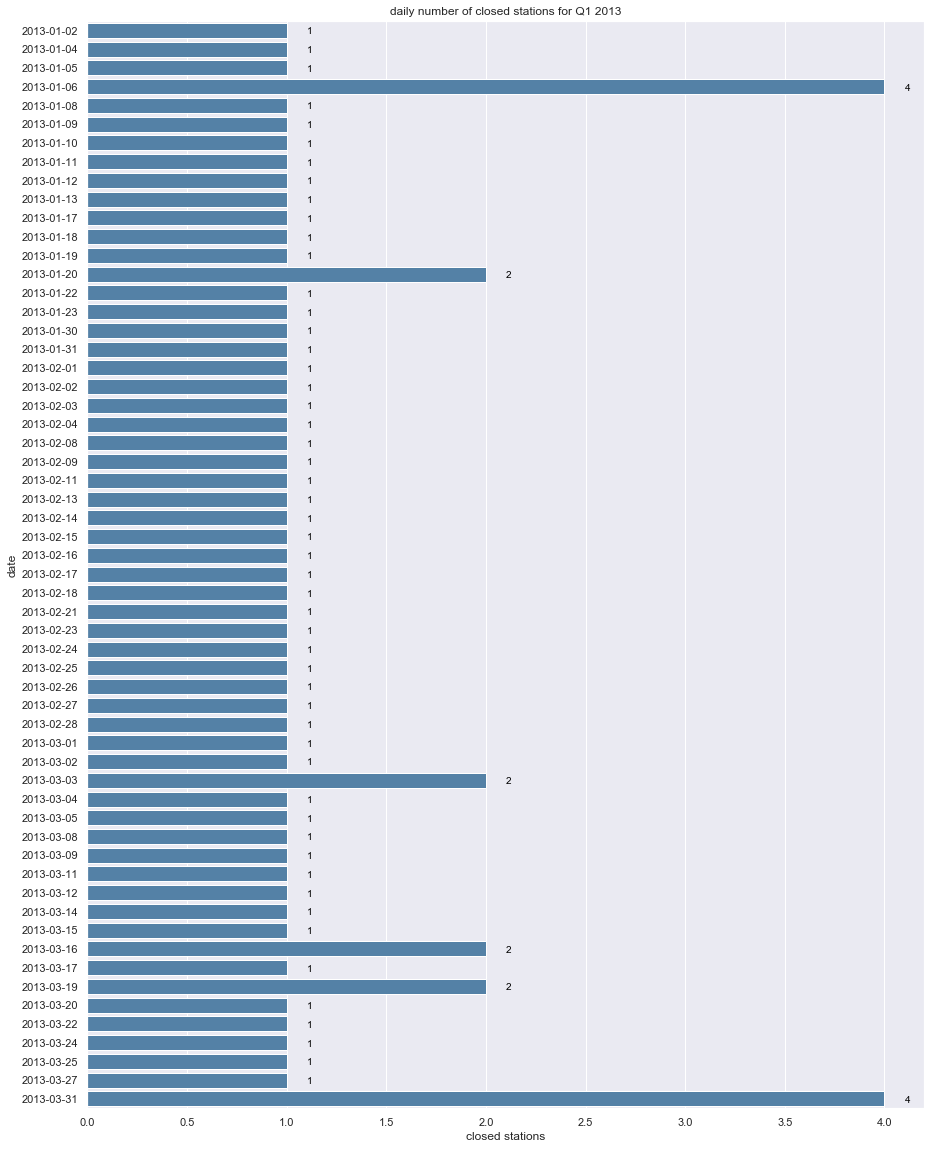

In [44]:
plot_closed(close_station)

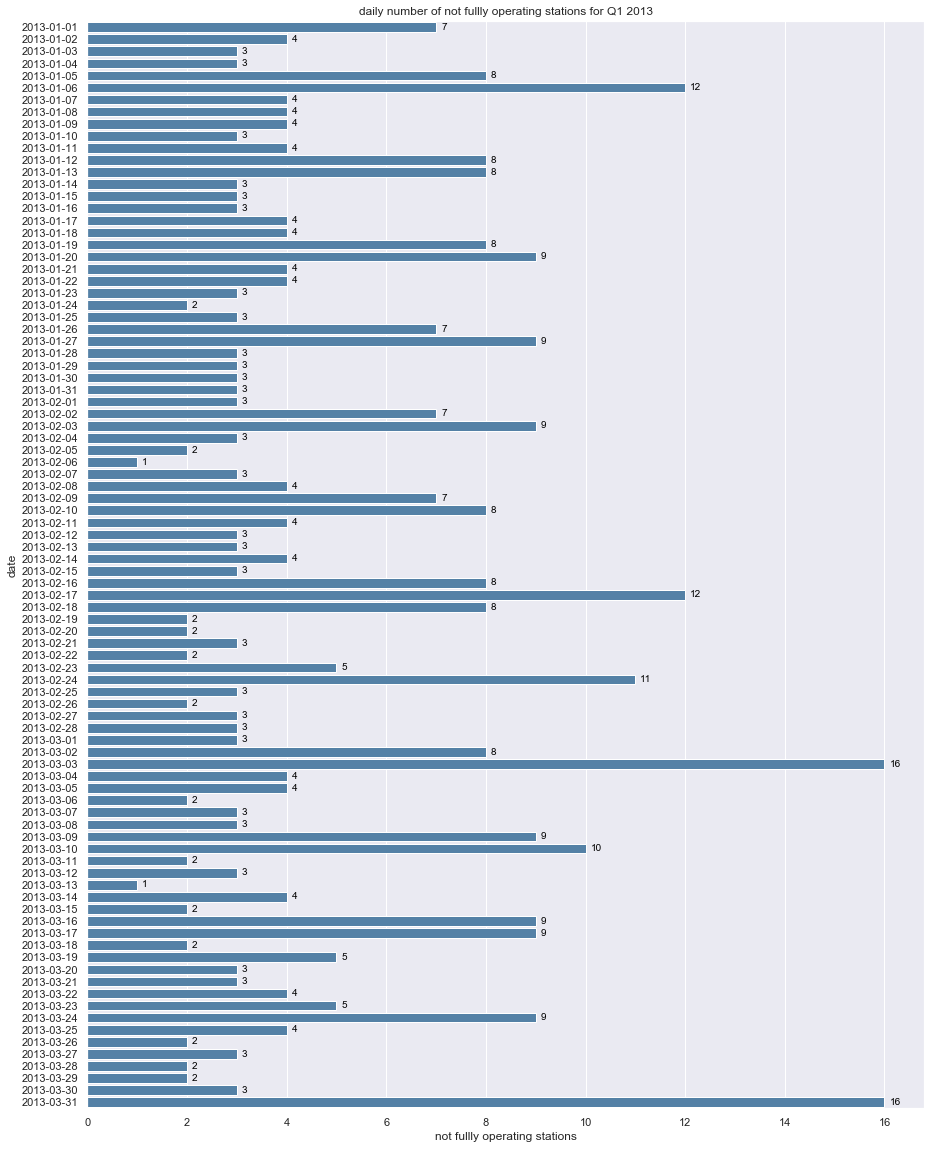

In [45]:
plot_not_full(not_full_station)

I also did some visualization for the 1st part as well, making the results more straightward, although for time reason I didn't adjust the diagrams one by one, as they are not required after all.

As for the diagrams for visulization questions, I did adjust them one by one, which should reflect my visualization skill and taste. :)

Any questions, feel free to reach out:  
lc3793@nyu.edu  
Lingyu (Cavlin) Cao